# Imports
---

In [1]:
import networkx as nx
import tsplib95
from mst import MST
import matplotlib.pyplot as plt
import benchmark
import os
import numpy as np
import time
import pandas as pd

# Helper Functions
---

In [45]:
def plot_graph(graph : nx.Graph, name : str):
    pos = nx.shell_layout(graph)
    nx.draw(graph, pos, with_labels=False)
    weights = {edge : str(graph.get_edge_data(edge[0], edge[1])["weight"]) for edge in graph.edges}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=weights)
    plt.savefig(name)
    plt.close()
    
def tour_cost(tsp_tour, graph: nx.Graph):
    total_cost = 0
    for i in range(len(tsp_tour) - 1):
        u, v = tsp_tour[i], tsp_tour[i+1]
        total_cost += graph.get_edge_data(u, v)['weight']
    return total_cost

def approximation_ratio(ALG_COST, OPT_COST):
    return ALG_COST / OPT_COST # Minimization problem

def get_dimension_from_tsp(directory_path):
    """
    Traverses a directory, reads .tsp files, and returns a list of tuples (filename, dimension).
    """
    dataset_info = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".tsp"):
            file_path = os.path.join(directory_path, filename)
            try:
                with open(file_path, 'r') as file:
                    problem = tsplib95.read(file)
                    dimension = problem.dimension
                    dataset_info.append((filename, dimension))
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    return dataset_info

def get_lowest_node_datasets(dataset_info, n=25):
    """
    Sorts dataset info by node count and returns the n datasets with the lowest node count.
    """
    dataset_info.sort(key=lambda item: item[1])  # Sort by node_count (second element of tuple)
    return dataset_info[:n]

# Christofides Algorithm
---
Steps:
1. Find a minimum spanning tree T of G.
2. Let O be the set of vertices with odd degree in T.
3. Find a minimum weight perfect matching M in the induced subgraph given by the vertices from O.
4. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.
5. Form an Eulerian circuit in H.
6. Make the circuit found in step 5 into a Hamiltonian circuit by skipping repeated vertices (shortcutting).


In [46]:
def christofides(graph: nx.Graph, mst_function='prims_k'):
    # Step 1: Compute the Minimum Spanning Tree (MST) using Kruskal's/Prim's Algorithm
    mst = MST()
    # mst_graph = mst.get_mst_kruskal_k(graph, k=20)  # Assuming an MST implementation using Kruskal's algorithm
    # mst_graph = mst.get_mst_kruskal(graph)
    if mst_function == 'prims_k':
        mst_graph = mst.get_mst_prims_k(graph=graph, k=20)
    elif mst_function == 'nx_mst':
        mst_graph = nx.algorithms.tree.minimum_spanning_tree(graph, weight='weight')
        
    plot_graph(mst_graph, 'mst.png')

    # Step 2: Identify vertices with odd degree and create a subgraph
    odd_nodes = MST.get_odd_degree_nodes(mst_graph)
    subgraph = nx.subgraph(graph, odd_nodes)
    plot_graph(subgraph, name='subgraph.png')

    # Step 3: Find the minimum cost perfect matching using Blossom Algorithm (Shrinks odd-length cycles aka BLOSSOMS)
    # Using the Blossom algorithm via nx.max_weight_matching (-weights)
    new_graph = nx.Graph()
    for e in subgraph.edges:
        new_graph.add_edge(e[0], e[1], weight=-subgraph.get_edge_data(e[0], e[1])['weight'])

    set_matching = nx.max_weight_matching(new_graph, maxcardinality=True)
    # print("Minimum Cost Perfect Matching Pairs:", set_matching)

    # Add the matching edges to create a multigraph
    matching_graph = nx.Graph()
    for m in set_matching:
        matching_graph.add_edge(m[0], m[1], weight=graph.get_edge_data(m[0], m[1])['weight'])

    plot_graph(matching_graph, name='matching_graph.png')

    # Step 4: Combine the MST and matching graph to form an Eulerian graph
    eulerian_graph = nx.MultiGraph(mst_graph)
    eulerian_graph.add_edges_from(matching_graph.edges(data=True))
    # plot_graph(eulerian_graph, name='eulerian_graph.png')

    # Step 5: Compute the Eulerian circuit and shortcut to form the TSP tour
    eulerian_circuit = list(nx.eulerian_circuit(eulerian_graph))
    tsp_tour = []
    visited = set()
    total_cost = 0

    for u, v in eulerian_circuit:
        if u not in visited:
            tsp_tour.append(u)
            visited.add(u)
        total_cost += graph.get_edge_data(u, v)['weight']
    print("Total cost of Eulerian circuit:", total_cost)

    # tsp_tour = [eulerian_circuit[0][0]]  # Start from the first vertex in the Eulerian circuit
    # visited = set(tsp_tour)

    # while len(visited) < len(graph.nodes):
    #     current_vertex = tsp_tour[-1]
    #     next_vertex = None
    #     min_weight = float('inf')
        
    #     for neighbor in graph.neighbors(current_vertex):
    #         if neighbor not in visited:
    #             weight = graph.get_edge_data(current_vertex, neighbor)['weight']
    #             if weight < min_weight:
    #                 min_weight = weight
    #                 next_vertex = neighbor
        
    #     if next_vertex is not None:
    #         tsp_tour.append(next_vertex)
    #         visited.add(next_vertex)
    
    tsp_tour.append(tsp_tour[0])  # Complete the tour by returning to the start
    
    # Step 6: Removing shortcuts to form the TSP tour using traingle inequality (Hamiltionian cycle)
    for i in range(len(tsp_tour) - 1):
        a, b, c = tsp_tour[i - 1], tsp_tour[i], tsp_tour[(i + 1) % len(tsp_tour)]
        if graph.has_edge(a, c) and graph[a][c]['weight'] <= graph[a][b]['weight'] + graph[b][c]['weight']:
            continue  # Triangle inequality holds
        
    return tsp_tour


In [47]:
# train_datasets = ['datasets/brg180.tsp', 'datasets/eil101.tsp', 'datasets/eil51.tsp', 'datasets/eil76.tsp', 'datasets/fri26.tsp', 'datasets/gr17.tsp', 'datasets/rat99.tsp', 'datasets/st70.tsp']

# for dataset in train_datasets:
#     curr_dataset = dataset.split('/')[1][:-4]
#     print("Dataset Used: ", curr_dataset)
#     file = open(dataset)
#     graph = tsplib95.read(file).get_graph()
#     tsp_tour = christofides(graph)

#     optimal_cost = benchmark.optimal_values[curr_dataset]
#     total_cost = tour_cost(tsp_tour, graph)

#     print("Final TSP Tour:", tsp_tour)
#     print("Final Cost of the TSP Tour:", total_cost)
#     print("Optimal Cost of the TSP Tour:", optimal_cost)
#     print("Approximation Ratio:", approximation_ratio(total_cost, optimal_cost))
#     print("--------------------------------------------------")
    

# Experiment
---

In [48]:
dataset_dir = "tsp_dataset"
# Get all datasets with node counts
dataset_info = get_dimension_from_tsp(dataset_dir)
print("All Datasets with Node Counts:")
for filename, node_count in dataset_info:
    print(f"{filename}: {node_count}")

# Get 25 datasets with lowest node counts
lowest_datasets = get_lowest_node_datasets(dataset_info, n=50)
print("\n25 Datasets with Lowest Node Counts:")
for filename, node_count in lowest_datasets:
    print(f"{filename}: {node_count}")

All Datasets with Node Counts:
a280.tsp: 280
ali535.tsp: 535
bayg29.tsp: 29
bays29.tsp: 29
berlin52.tsp: 52
bier127.tsp: 127
brazil58.tsp: 58
burma14.tsp: 14
ch130.tsp: 130
ch150.tsp: 150
d1291.tsp: 1291
d1655.tsp: 1655
d198.tsp: 198
d493.tsp: 493
d657.tsp: 657
dantzig42.tsp: 42
dsj1000.tsp: 1000
eil101.tsp: 101
eil51.tsp: 51
eil76.tsp: 76
fl1400.tsp: 1400
fl417.tsp: 417
fnl4461.tsp: 4461
fri26.tsp: 26
gil262.tsp: 262
gr120.tsp: 120
gr137.tsp: 137
gr17.tsp: 17
gr202.tsp: 202
gr21.tsp: 21
gr229.tsp: 229
gr24.tsp: 24
gr431.tsp: 431
gr48.tsp: 48
gr666.tsp: 666
gr96.tsp: 96
hk48.tsp: 48
kroA100.tsp: 100
kroA150.tsp: 150
kroA200.tsp: 200
kroB100.tsp: 100
kroB150.tsp: 150
kroB200.tsp: 200
kroC100.tsp: 100
kroD100.tsp: 100
kroE100.tsp: 100
lin105.tsp: 105
lin318.tsp: 318
linhp318.tsp: 318
nrw1379.tsp: 1379
p654.tsp: 654
pa561.tsp: 561
pcb1173.tsp: 1173
pcb3038.tsp: 3038
pcb442.tsp: 442
pla7397.tsp: 7397
pr1002.tsp: 1002
pr107.tsp: 107
pr124.tsp: 124
pr136.tsp: 136
pr144.tsp: 144
pr152.tsp: 15

In [49]:

def plot_graphs(data_runtimes, data_mst_costs, data_christofides_costs, data_approx_ratios, output_dir):
      # Plotting graph of runtime vs graph dimension
      # Prepare data
      x = [dim for (dim, _) in data_runtimes.values()]  # Graph dimensions
      y = [runtime for (_, runtime) in data_runtimes.values()]  # Runtimes
      plt.figure(figsize=(10, 6))
      plt.scatter(x, y, s=10, c="b", marker="o", label="Data Points")
      coefficients = np.polyfit(x, y, 2)
      # Generate x values for the fitted line (more points make the line smoother)
      x_fit = np.linspace(min(x), max(x), 100)
      # Calculate y values for the fitted line using the coefficients
      y_fit = np.polyval(coefficients, x_fit)
      # Plot the fitted curve
      plt.plot(x_fit, y_fit, color="r", linestyle="-", label="Fitted Curve (degree 2)")
      plt.xlabel("Graph Dimension")
      plt.ylabel("Runtime (seconds)")
      plt.title("Christofides Algorithm Runtime vs Graph Dimension (Probabilistic Prim's)")
      plt.grid(True)
      plt.legend()

      # Save the plot
      plt.savefig(os.path.join(output_dir, "runtime_vs_dimension_det.png"))

      # Show the plot
      plt.show()


      # Plotting graph of MST comparison
      x = list(data_mst_costs.keys())
      y1 = [cost for (cost, _) in data_mst_costs.values()]
      y2 = [cost for (_, cost) in data_mst_costs.values()]

      plt.figure(figsize=(12, 7))
      plt.plot(x, y1, marker='o', linestyle='-', label="Probabilistic Prim's (k=20)")
      plt.plot(x, y2, marker='x', linestyle='--', label="NetworkX minimum_spanning_tree")
      plt.xlabel("Dataset")
      plt.ylabel("MST Cost")
      plt.title("Comparison of MST Costs")
      plt.xticks(rotation=45, ha="right")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.savefig(os.path.join(output_dir, "mst_comparison_det.png"))
      plt.close()

      #Plotting graph of christofides cost comparison
      x = list(data_christofides_costs.keys())
      y1 = [cost for (cost, _) in data_christofides_costs.values()]
      y2 = [cost for (_, cost) in data_christofides_costs.values()]
      plt.figure(figsize=(12, 7))
      plt.plot(x, y1, marker='o', linestyle='-', label="Christofides (Probabilistic Prim's)")
      plt.plot(x, y2, marker='x', linestyle='--', label="Christofides (NetworkX)")
      plt.xlabel("Dataset")
      plt.ylabel("Christofides Cost")
      plt.title("Comparison of Christofides Costs")
      plt.xticks(rotation=45, ha="right")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.savefig(os.path.join(output_dir, "christofides_comparison_det.png"))
      plt.close()

In [50]:
# def run_experiment(datasets_dir, output_dir, plot=False):
#   """
#   Runs experiments on lowest dimension datasets, and saves result and plots
#   """
#   # Create output directory if it doesn't exist
#   os.makedirs(output_dir, exist_ok=True)
  
#   # Data storage for graphs
#   data_runtimes = {}
#   data_mst_costs = {}
#   data_christofides_costs = {} # Added to store christofides data
#   data_apx_ratios = {}

#   for filename, dimension in lowest_datasets:
#         dataset_path = os.path.join(datasets_dir, filename)
#         print(f"\nProcessing dataset: {filename}")
#         curr_dataset = filename[:-4]

#         try:
#             with open(dataset_path, 'r') as file:
#                 graph = tsplib95.read(file).get_graph()
            
#             # 3. Run Christofides and get runtime for both MSTs
#             start_time = time.time()
#             tsp_tour_prims_k = christofides(graph, mst_function='prims_k') # calls the christofides algorithm.
#             end_time = time.time()
#             runtime_prims_k = end_time - start_time

#             start_time = time.time()
#             tsp_tour_networkx = christofides(graph, mst_function='nx_mst')
#             end_time = time.time()
#             runtime_networkx = end_time - start_time


#             # 4. Cost and Approximation Ratio
#             total_cost_prims_k = tour_cost(tsp_tour_prims_k, graph)
#             total_cost_networkx = tour_cost(tsp_tour_networkx, graph)
#             optimal_cost = benchmark.optimal_values[curr_dataset]

#             if optimal_cost is None:
#                 print(f"Warning: Optimal cost not found for {curr_dataset}. Using approximation ratio as 1")
#                 approx_ratio_prims_k = 1
#                 approx_ratio_networkx = 1
#             else:
#                 approx_ratio_prims_k = approximation_ratio(total_cost_prims_k, optimal_cost)
#                 approx_ratio_networkx = approximation_ratio(total_cost_networkx, optimal_cost)


#             # 6. Save results
#             with open(os.path.join(output_dir, 'results.txt'), 'a') as f:
#               f.write(f"Dataset: {curr_dataset}\n")
#               f.write(f"Algorithm Cost (Probabilistic Prim's): {total_cost_prims_k}\n")
#               f.write(f"Algorithm Cost (NetworkX): {total_cost_networkx}\n")
#               f.write(f"Optimal Cost: {optimal_cost}\n")
#               f.write(f"Approximation Ratio (Probabilistic Prim's): {approx_ratio_prims_k}\n")
#               f.write(f"Approximation Ratio (NetworkX): {approx_ratio_networkx}\n")
#               f.write(f"Runtime (Probabilistic Prim's) (seconds): {runtime_prims_k}\n")
#               f.write(f"Runtime (NetworkX) (seconds): {runtime_networkx}\n")
#               f.write("--------------------------------------------------\n")

#             # 7. Save data for graphs
#             data_runtimes[curr_dataset] = (dimension, runtime_prims_k) # Save runtime only for one version of christofides. We assume the runtime is similar for both
            
#             mst = MST()
#             mst_prims = mst.get_mst_prims_k(graph=graph, k=20)
#             data_mst_costs[curr_dataset] = (mst.get_mst_cost(), nx.minimum_spanning_tree(graph, weight='weight').size(weight='weight'))
#             data_christofides_costs[curr_dataset] = (total_cost_prims_k, total_cost_networkx)
#             data_apx_ratios[curr_dataset] = approx_ratio_prims_k
            

#         except Exception as e:
#             print(f"Error processing {filename}: {e}")

#   # 8. Generate graphs
#   if plot:
#     plot_graphs(data_runtimes, data_mst_costs, data_christofides_costs, data_apx_ratios, output_dir)



In [51]:
def run_experiment(datasets_dir, output_dir, plot=False):
    """
    Runs experiments on lowest dimension datasets, saves results in CSV, and optionally generates plots.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Prepare CSV file
    csv_file = os.path.join(output_dir, 'results.csv')
    csv_columns = [
        "name", "dimension", "opt_tour_length", "c_tour_length_prims_k", "c_tour_length_nx_mst",
        "mst_cost_prims_k", "mst_cost_nx_mst", "c_apx_ratio_prims_k", "c_apx_ratio_nx_mst",
        "elapsed_time_prims_k", "elapsed_time_nx_mst"
    ]

    with open(csv_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=csv_columns)
        writer.writeheader()

    # Data storage for graphs
    data_runtimes = {}
    data_mst_costs = {}
    data_christofides_costs = {}
    data_apx_ratios = {}

    for filename, dimension in lowest_datasets:
        dataset_path = os.path.join(datasets_dir, filename)
        print(f"\nProcessing dataset: {filename}")
        curr_dataset = filename[:-4]

        try:
            with open(dataset_path, 'r') as file:
                graph = tsplib95.read(file).get_graph()

            # Compute MST costs for both methods
            mst = MST()
            mst_graph_prims_k = mst.get_mst_prims_k(graph=graph, k=20)
            mst_cost_prims_k = mst.get_mst_cost()

            mst_graph_nx_mst = nx.minimum_spanning_tree(graph, weight='weight')
            mst_cost_nx_mst = mst_graph_nx_mst.size(weight='weight')

            # Run Christofides Algorithm with both MST methods
            start_time = time.time()
            tsp_tour_prims_k = christofides(graph, mst_function='prims_k')
            end_time = time.time()
            runtime_prims_k = end_time - start_time

            start_time = time.time()
            tsp_tour_nx_mst = christofides(graph, mst_function='nx_mst')
            end_time = time.time()
            runtime_nx_mst = end_time - start_time

            # Compute Christofides tour costs
            total_cost_prims_k = tour_cost(tsp_tour_prims_k, graph)
            total_cost_nx_mst = tour_cost(tsp_tour_nx_mst, graph)

            # Compute approximation ratios
            optimal_cost = benchmark.optimal_values[curr_dataset]

            if optimal_cost is None:
                print(f"Warning: Optimal cost not found for {curr_dataset}. Using approximation ratio as 1")
                approx_ratio_prims_k = 1
                approx_ratio_nx_mst = 1
            else:
                approx_ratio_prims_k = approximation_ratio(total_cost_prims_k, optimal_cost)
                approx_ratio_nx_mst = approximation_ratio(total_cost_nx_mst, optimal_cost)

            # Write to CSV
            with open(csv_file, mode='a', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=csv_columns)
                writer.writerow({
                    "name": curr_dataset,
                    "dimension": dimension,
                    "opt_tour_length": optimal_cost,
                    "c_tour_length_prims_k": total_cost_prims_k,
                    "c_tour_length_nx_mst": total_cost_nx_mst,
                    "mst_cost_prims_k": mst_cost_prims_k,
                    "mst_cost_nx_mst": mst_cost_nx_mst,
                    "c_apx_ratio_prims_k": approx_ratio_prims_k,
                    "c_apx_ratio_nx_mst": approx_ratio_nx_mst,
                    "elapsed_time_prims_k": runtime_prims_k,
                    "elapsed_time_nx_mst": runtime_nx_mst
                })

            # Save data for graphs
            data_runtimes[curr_dataset] = (dimension, runtime_prims_k)
            data_mst_costs[curr_dataset] = (mst_cost_prims_k, mst_cost_nx_mst)
            data_christofides_costs[curr_dataset] = (total_cost_prims_k, total_cost_nx_mst)
            data_apx_ratios[curr_dataset] = (approx_ratio_prims_k, approx_ratio_nx_mst)

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Generate graphs if needed
    if plot:
        plot_graphs(data_runtimes, data_mst_costs, data_christofides_costs, data_apx_ratios, output_dir)

    print(f"Results saved in {csv_file}")


In [ ]:
datasets_dir = 'tsp_dataset'
algo_plots_dir = 'algo_plots'
run_experiment(datasets_dir, algo_plots_dir, plot=True)

# Plots
---

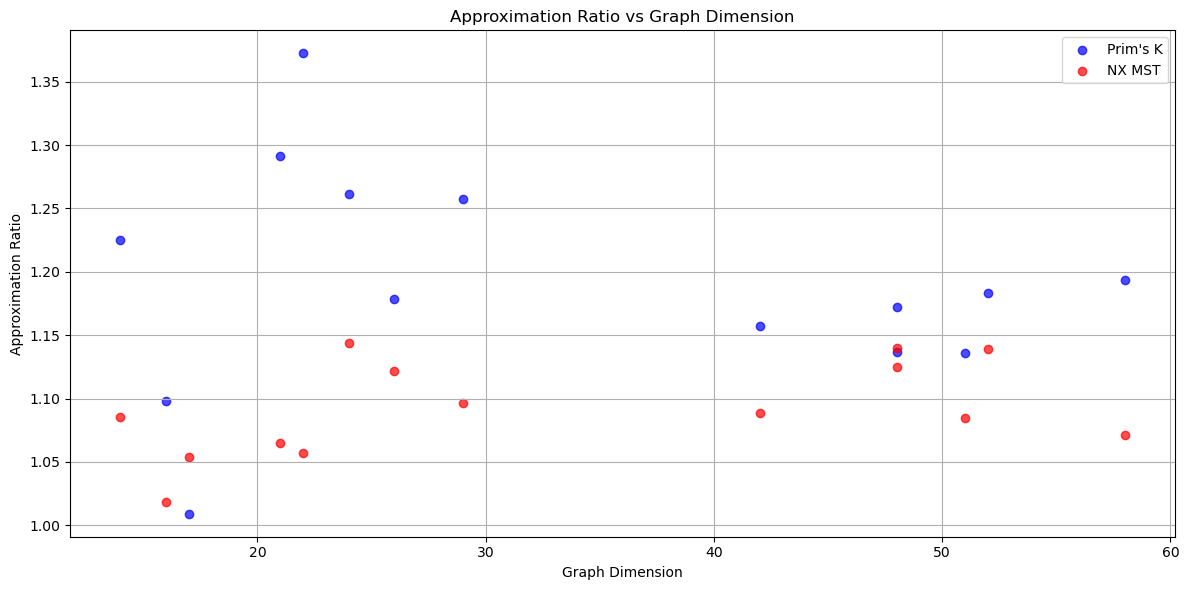

In [53]:
# Load the data into a pandas DataFrame
csv_file = 'algo_plots/results.csv'  # Update with your actual CSV file path
data = pd.read_csv(csv_file)

# Create scatter plots for approximation ratios vs dimensions
plt.figure(figsize=(12, 6))

# Scatter plot for Prim's K-based MST
plt.scatter(data['dimension'], data['c_apx_ratio_prims_k'], label="Prim's K", color='blue', alpha=0.7)

# Scatter plot for NetworkX MST
plt.scatter(data['dimension'], data['c_apx_ratio_nx_mst'], label='NX MST', color='red', alpha=0.7)

# Add labels, legend, and title
plt.xlabel('Graph Dimension')
plt.ylabel('Approximation Ratio')
plt.title('Approximation Ratio vs Graph Dimension')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


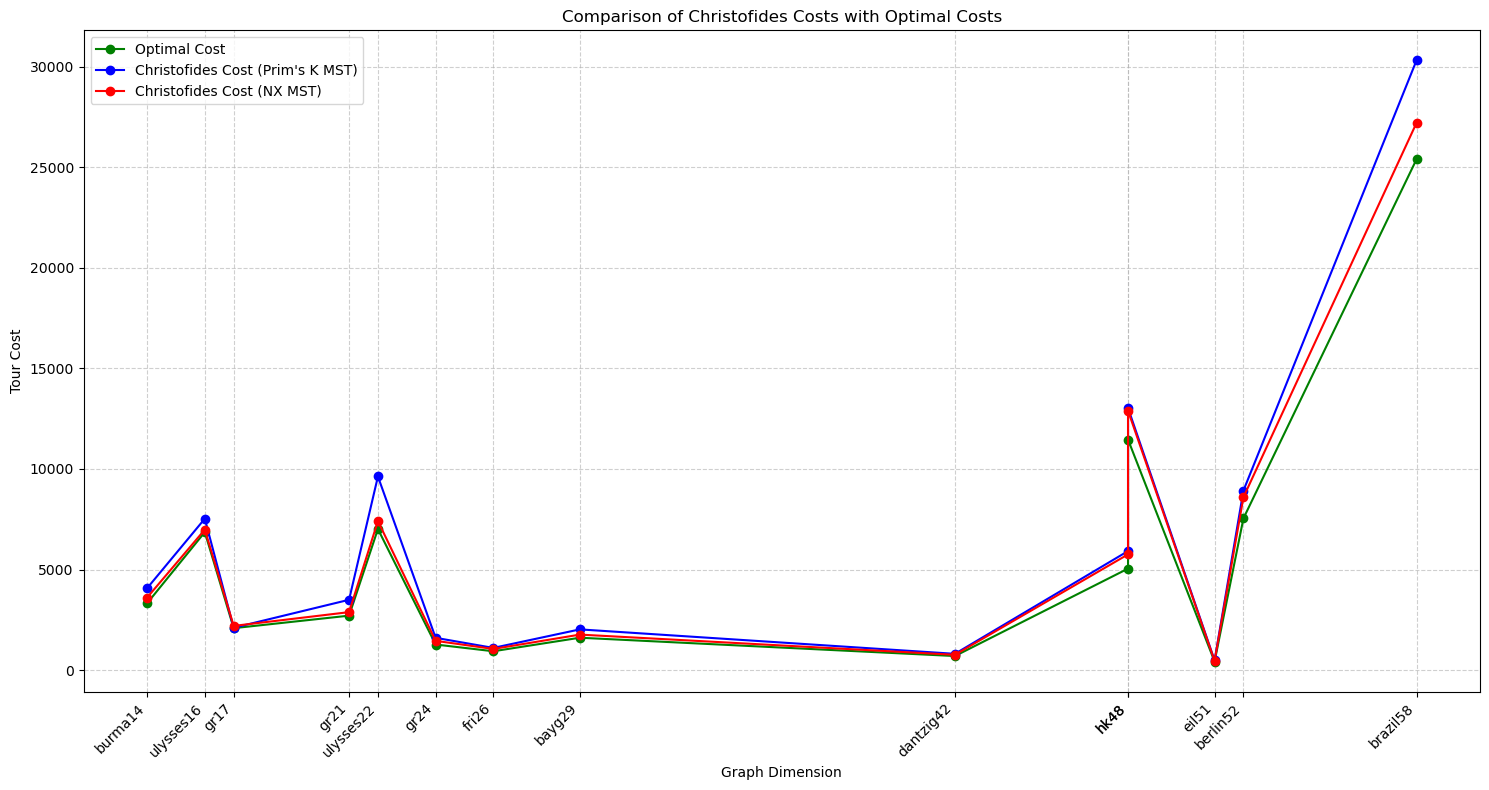

In [54]:
# Load the data into a pandas DataFrame
csv_file = 'algo_plots/results.csv'  # Update with your actual CSV file path
data = pd.read_csv(csv_file)

# Sort data by graph dimension for better visualization
data = data.sort_values(by='dimension')

# Plot the costs
plt.figure(figsize=(15, 8))
plt.plot(data['dimension'], data['opt_tour_length'], label='Optimal Cost', marker='o', color='green')
plt.plot(data['dimension'], data['c_tour_length_prims_k'], label="Christofides Cost (Prim's K MST)", marker='o', color='blue')
plt.plot(data['dimension'], data['c_tour_length_nx_mst'], label='Christofides Cost (NX MST)', marker='o', color='red')

# Add labels and title
plt.xlabel('Graph Dimension')
plt.ylabel('Tour Cost')
plt.title('Comparison of Christofides Costs with Optimal Costs')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

# Highlight the graph dimension as x-axis ticks
plt.xticks(data['dimension'], labels=data['name'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()
